In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [2]:
path = 'data/'

TRAIN_DATA_FILE = path + 'train.csv'
TEST_DATA_FILE = path + 'test.csv'

In [3]:
train_df = pd.read_csv(TRAIN_DATA_FILE)
test_df = pd.read_csv(TEST_DATA_FILE)

In [4]:
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [5]:
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm

# replace urls
re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                    .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                    re.MULTILINE|re.UNICODE)
# replace ips
re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

# setup tokenizer
tokenizer = WordPunctTokenizer()

vocab = Counter()

def text_to_wordlist(text, lower=False):
    # replace URLs
    text = re_url.sub("URL", text)
    
    # replace IPs
    text = re_ip.sub("IPADDRESS", text)
    
    # Tokenize
    text = tokenizer.tokenize(text)
    
    # optional: lower case
    if lower:
        text = [t.lower() for t in text]
    
    # Return a list of words
    vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments


list_sentences_train = list(train_df["comment_text"].fillna("NAN_WORD").values)
list_sentences_test = list(test_df["comment_text"].fillna("NAN_WORD").values)

comments = process_comments(list_sentences_train + list_sentences_test, lower=True)

Processing text dataset


100%|██████████| 312735/312735 [00:26<00:00, 11628.17it/s]


In [6]:
print("The vocabulary contains {} unique tokens".format(len(vocab)))

The vocabulary contains 365516 unique tokens


In [7]:
from gensim.models import Word2Vec

In [8]:
model = Word2Vec(comments, size=100, window=5, min_count=5, workers=16, sg=0, negative=5)

In [9]:
word_vectors = model.wv

In [10]:
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 70056


In [11]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 200

In [12]:
from keras.preprocessing.sequence import pad_sequences

word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in comments[:len(list_sentences_train)]]
test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  for comment in comments[len(list_sentences_train):]]

# pad
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_classes].values
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")
print('Shape of test_data tensor:', test_data.shape)

/Users/mosthusnejahan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)
Shape of test_data tensor: (153164, 200)


In [13]:
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))
# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass  

In [14]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

In [15]:
wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

# Inputs
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = wv_layer(comment_input)

# biGRU
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(64, return_sequences=False))(embedded_sequences)

# Output
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
preds = Dense(6, activation='sigmoid')(x)

# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=[])

In [16]:
hist = model.fit([data], y, validation_split=0.1,
                 epochs=10, batch_size=256, shuffle=True)

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 502s 3ms/step - loss: 0.1699 - val_loss: 0.0549
Epoch 2/10
143613/143613 [==============================] - 501s 3ms/step - loss: 0.0574 - val_loss: 0.0532
Epoch 3/10
143613/143613 [==============================] - 507s 4ms/step - loss: 0.0524 - val_loss: 0.0482
Epoch 4/10
143613/143613 [==============================] - 508s 4ms/step - loss: 0.0496 - val_loss: 0.0475
Epoch 5/10
143613/143613 [==============================] - 497s 3ms/step - loss: 0.0475 - val_loss: 0.0469
Epoch 6/10
143613/143613 [==============================] - 4106s 29ms/step - loss: 0.0470 - val_loss: 0.0456
Epoch 7/10
143613/143613 [==============================] - 507s 4ms/step - loss: 0.0452 - val_loss: 0.0456
Epoch 8/10
143613/143613 [==============================] - 512s 4ms/step - loss: 0.0444 - val_loss: 0.0451
Epoch 9/10
143613/143613 [==============================] - 539s 4ms/step - loss: 0

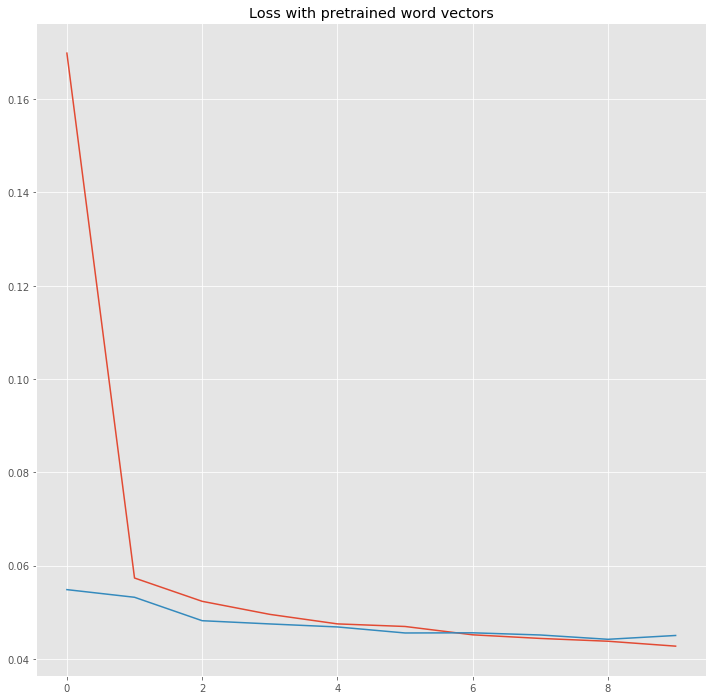

In [17]:
history = pd.DataFrame(hist.history)
plt.figure(figsize=(12,12));
plt.plot(history["loss"]);
plt.plot(history["val_loss"]);
plt.title("Loss with pretrained word vectors");
plt.show();

In [ ]:
wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     # weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

# Inputs
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = wv_layer(comment_input)

# biGRU
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(CuDNNLSTM(64, return_sequences=False))(embedded_sequences)

# Output
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
preds = Dense(6, activation='sigmoid')(x)

# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=[])

In [ ]:
hist = model.fit([data], y, validation_split=0.1,
                 epochs=10, batch_size=256, shuffle=True)

In [ ]:
history = pd.DataFrame(hist.history)
plt.figure(figsize=(12,12));
plt.plot(history["loss"]);
plt.plot(history["val_loss"]);
plt.title("Loss with random word vectors");
plt.show();